In [105]:
import joblib
import numpy as np
import pandas as pd

def q_history_to_df(q_history):
    rows = []
    for (over, runs, wickets), hist in q_history.items():
        for t, q in hist:
            rows.append({
                "over": over,
                "runs": runs,
                "wickets": wickets,
                "t": int(t),
                "Q_attack": float(q[0]),
                "Q_neutral": float(q[1]),
                "Q_defend": float(q[2]),
            })
    df = pd.DataFrame(rows)
    if df.empty:
        raise ValueError("q_history produced an empty DataFrame")
    return df

In [106]:

def policy_time_series(
    df,
    state_mask,
    tau,
    window=5_000,
):
    """
    Returns DataFrame with columns:
    t, pi_attack, pi_neutral, pi_defend
    """

    Q_cols = ["Q_attack", "Q_neutral", "Q_defend"]

    dfc = df.loc[state_mask].copy()
    if dfc.empty:
        raise ValueError("No rows after applying state class filter")

    dfc = dfc.sort_values("t")

    # rolling mean of Q-values
    dfc[Q_cols] = (
        dfc[Q_cols]
        .rolling(window=window, min_periods=window // 5)
        .mean()
    )

    dfc = dfc.dropna(subset=Q_cols)

    # softmax
    Q = dfc[Q_cols].values
    Q = Q / tau
    Q = Q - Q.max(axis=1, keepdims=True)
    P = np.exp(Q)
    P /= P.sum(axis=1, keepdims=True)

    dfc["pi_attack"] = P[:, 0]
    dfc["pi_neutral"] = P[:, 1]
    dfc["pi_defend"] = P[:, 2]

    return dfc[["t", "pi_attack", "pi_neutral", "pi_defend"]]




In [ ]:
import matplotlib.pyplot as plt

def plot_policy_comparison(series_by_tau, title_prefix="Policy evolution"):
    """
    series_by_tau: dict[tau -> DataFrame returned by policy_time_series]

    Produces ONE figure per tau (history).
    """

    for tau, dfp in series_by_tau.items():
        plt.figure(figsize=(8, 5))

        plt.plot(dfp["t"], dfp["pi_attack"],  label="Attack")
        plt.plot(dfp["t"], dfp["pi_neutral"], label="Neutral", linestyle="--")
        plt.plot(dfp["t"], dfp["pi_defend"],  label="Defend", linestyle=":")

        plt.xlabel("Update step t")
        plt.ylabel("Policy probability")
        plt.title(f"{title_prefix} (Temperature = {tau}) (Num. States = {len(dfp)})")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [118]:
# ---- load histories ----
q_hist_01 = joblib.load("../data/temperature-0.1/batting/q_history.joblib")
q_hist_05 = joblib.load("../data/temperature-0.5/batting/q_history.joblib")
q_hist_10 = joblib.load("../data/temperature-1.0/batting/q_history.joblib")

df_01 = q_history_to_df(q_hist_01)
df_05 = q_history_to_df(q_hist_05)
df_10 = q_history_to_df(q_hist_10)

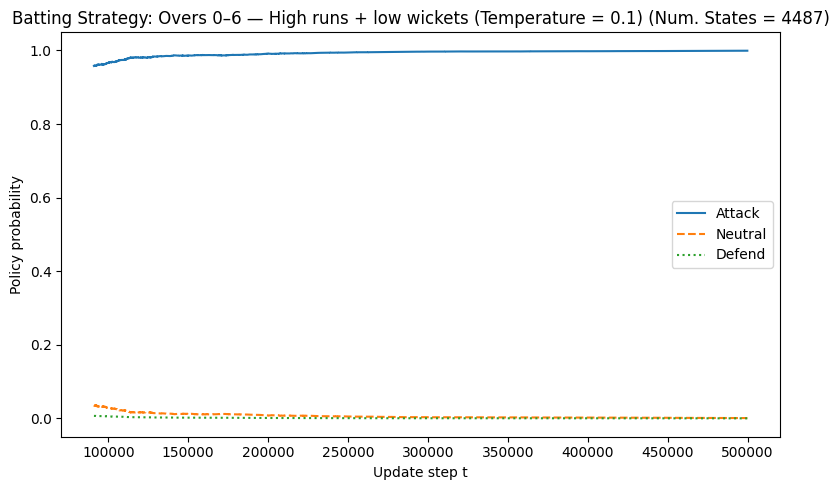

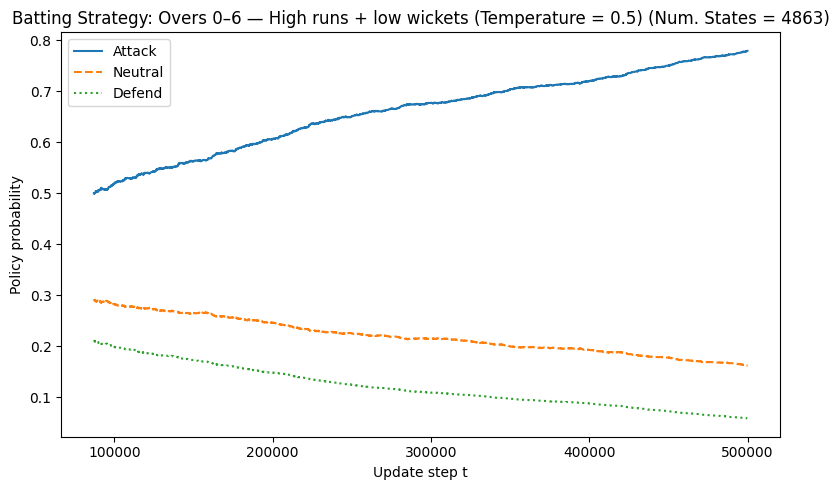

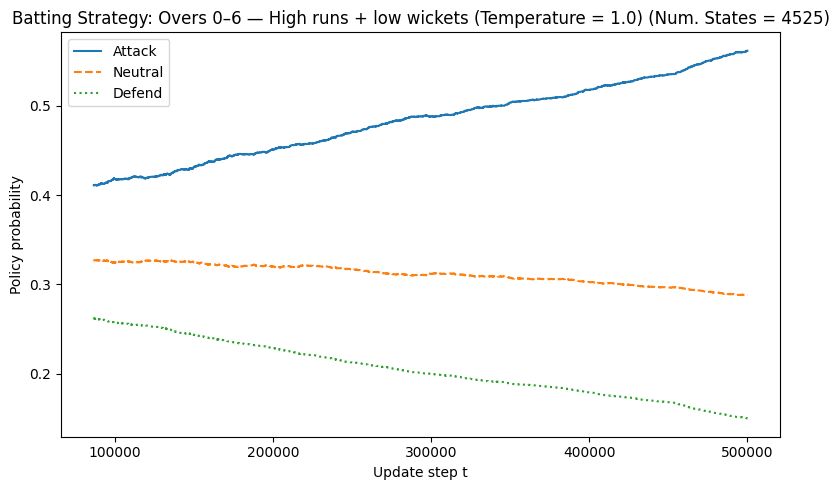

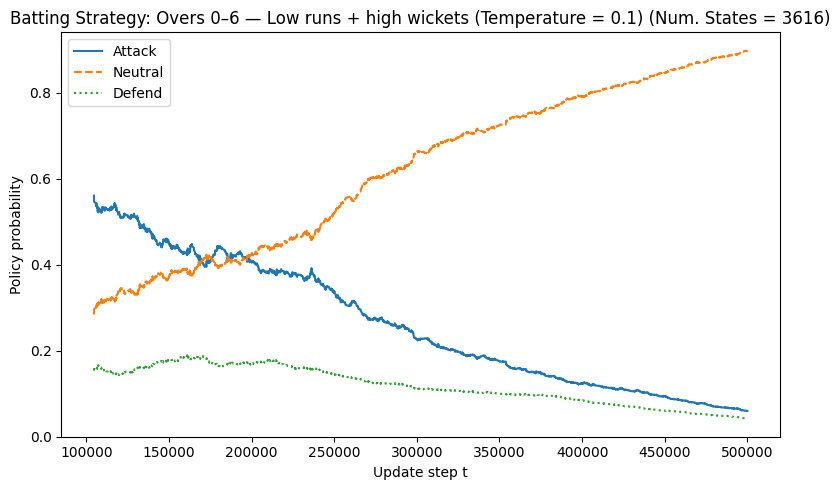

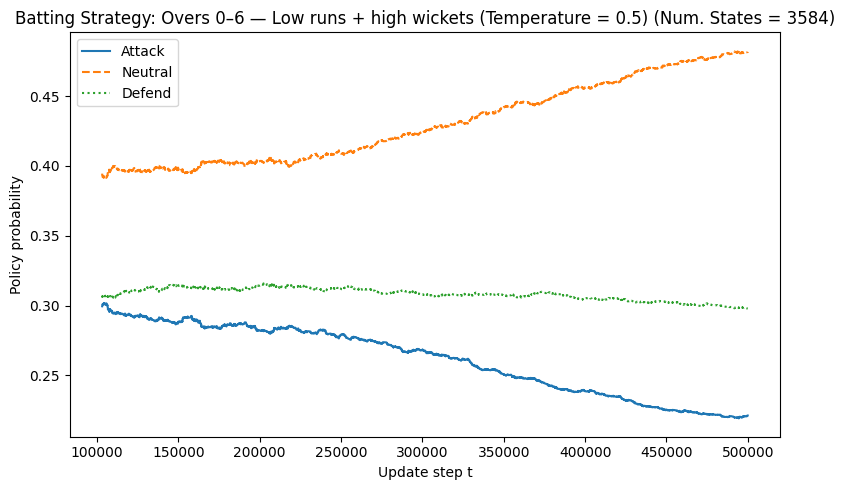

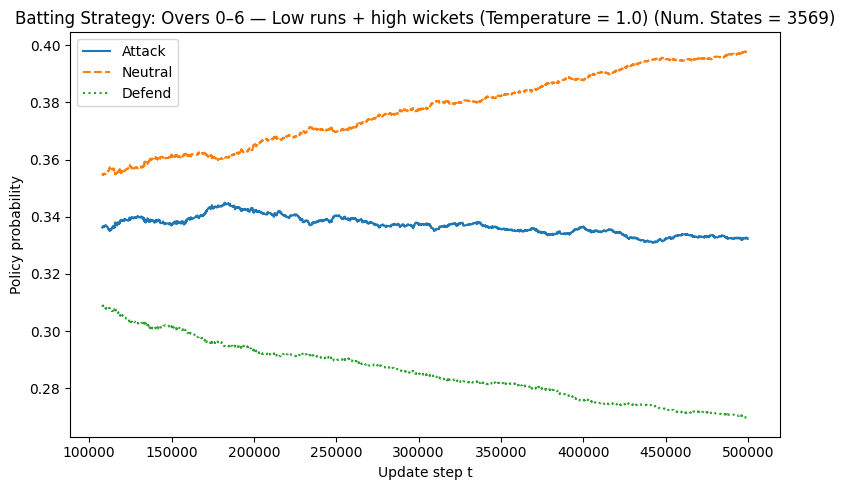

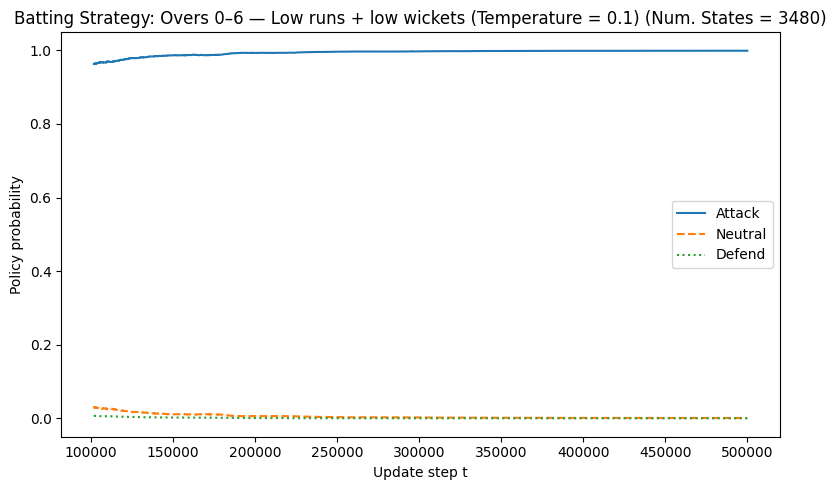

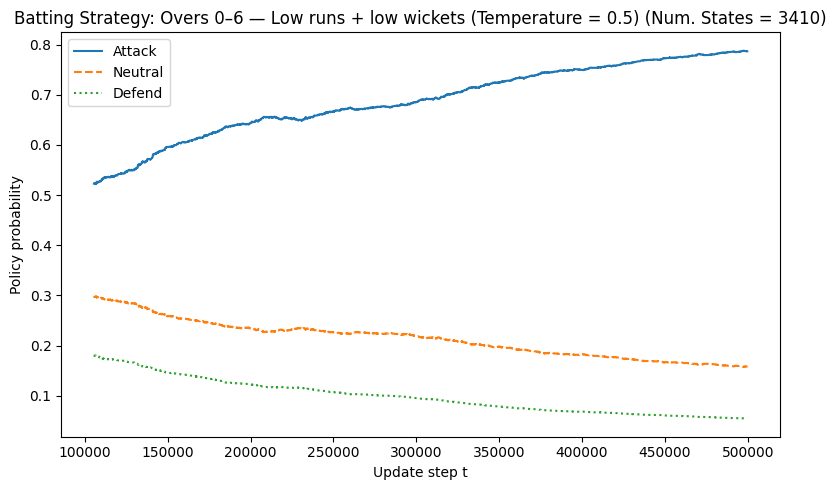

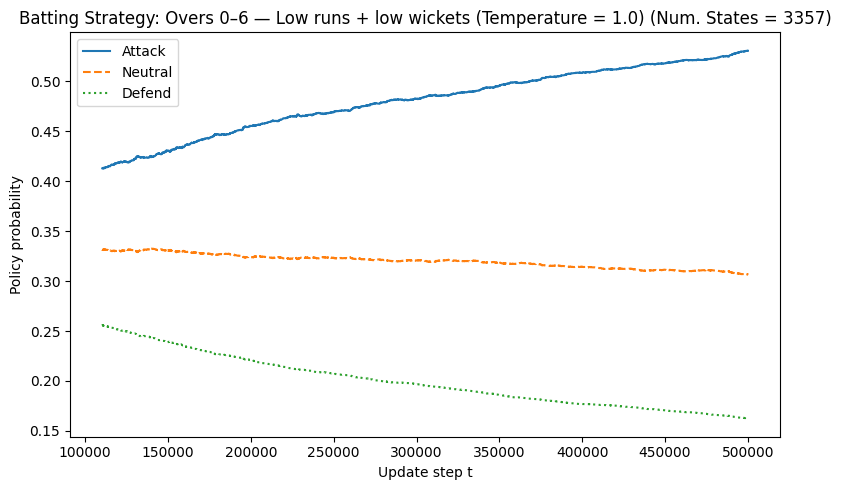

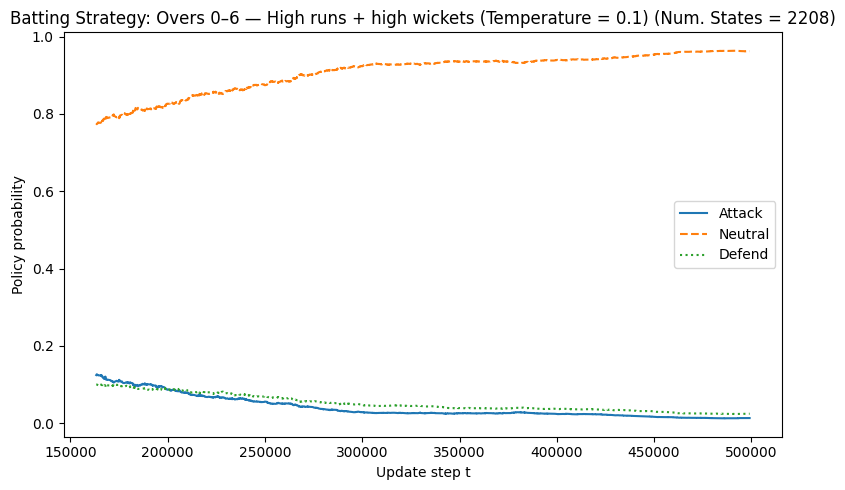

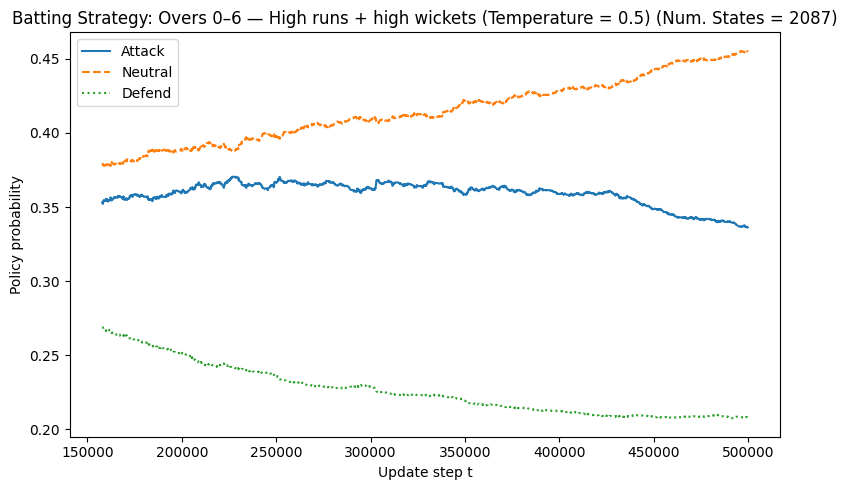

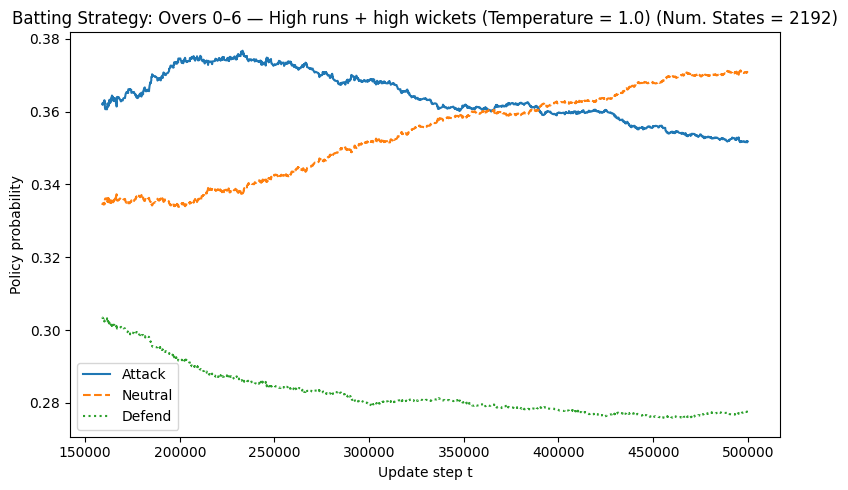

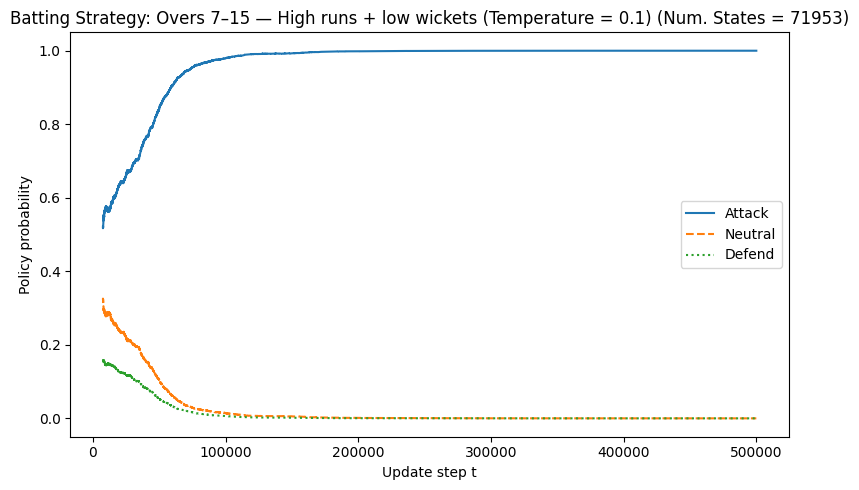

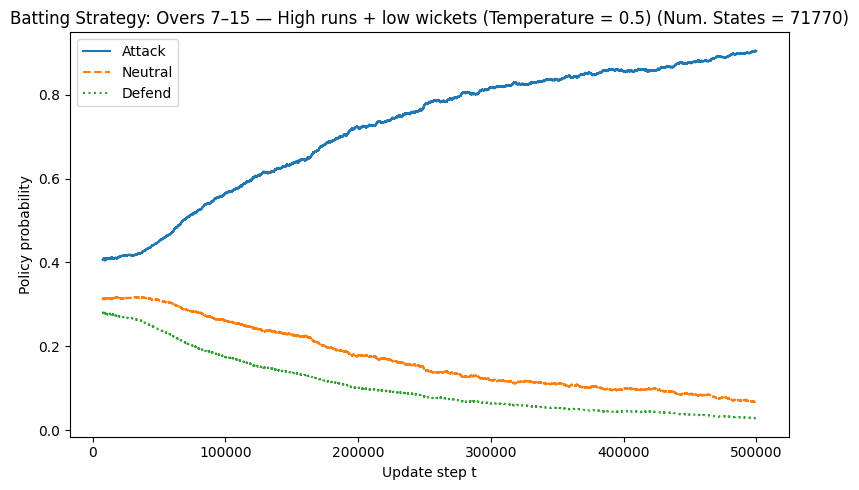

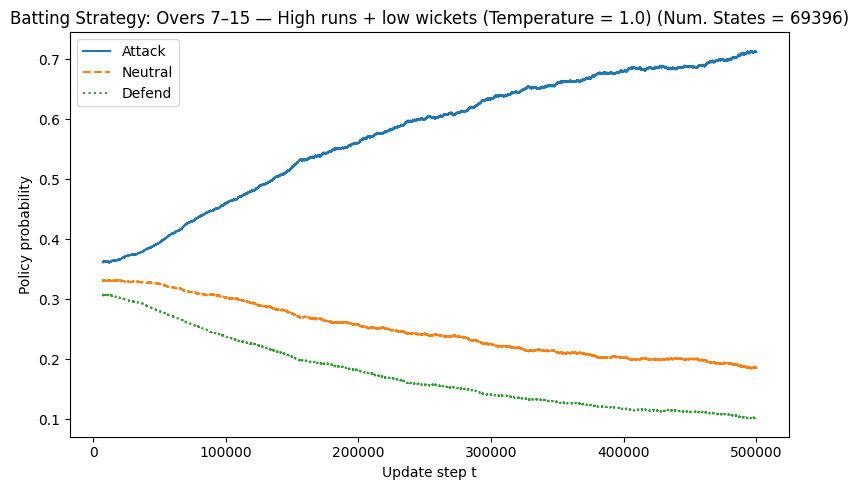

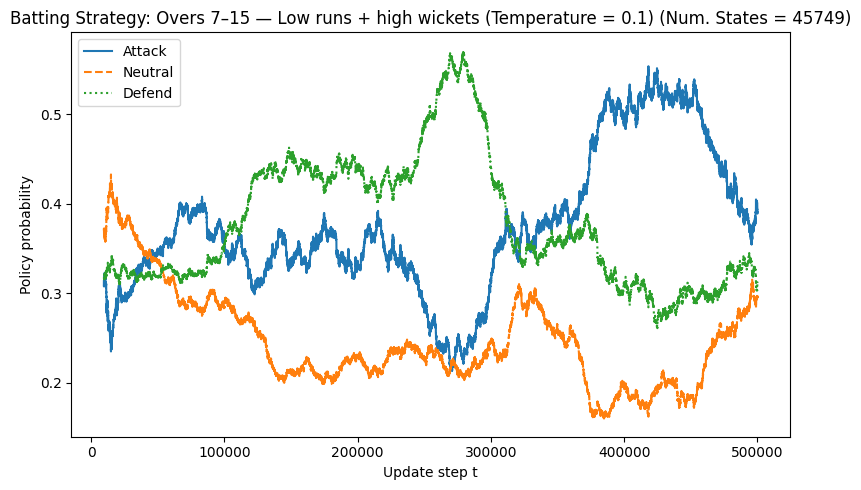

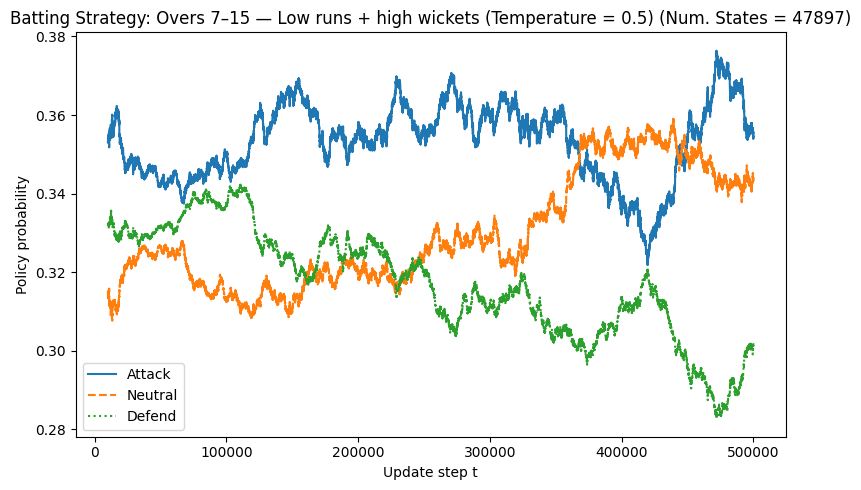

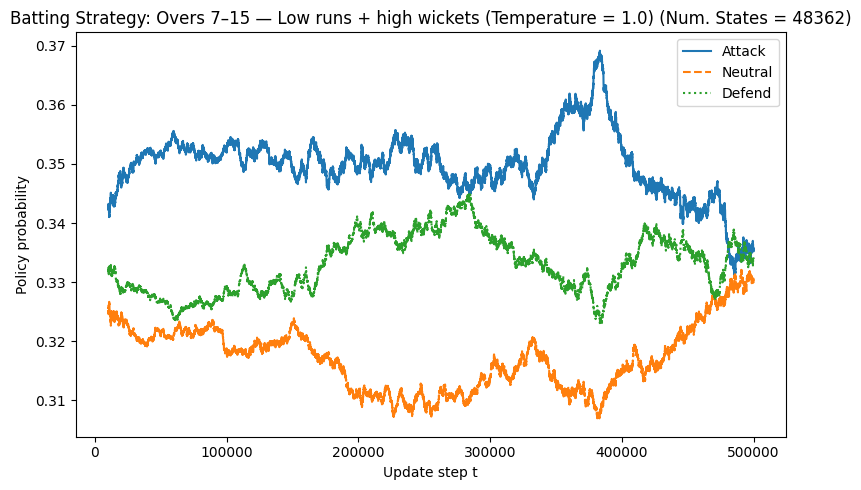

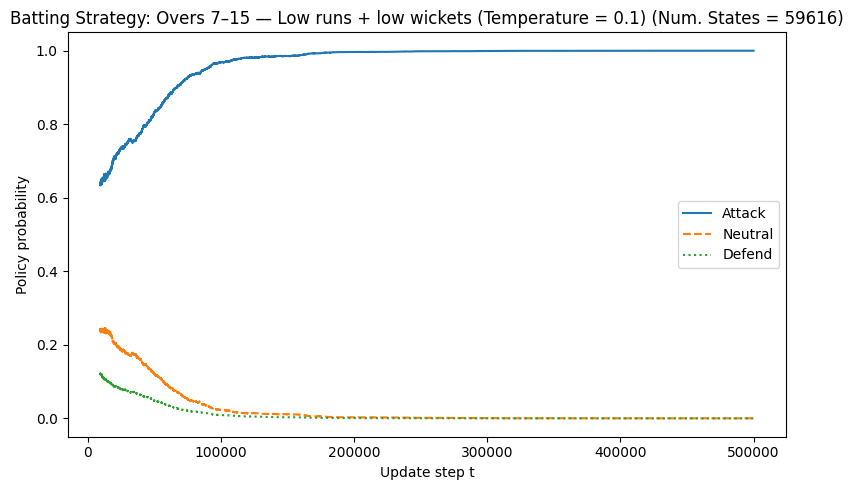

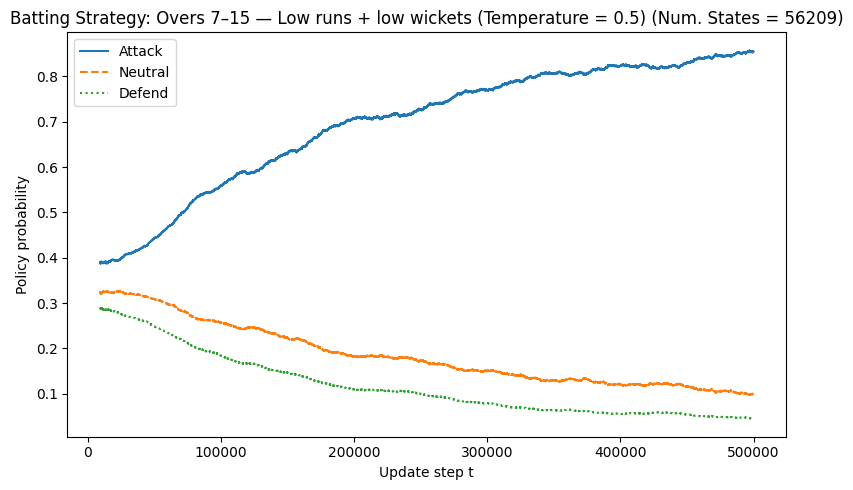

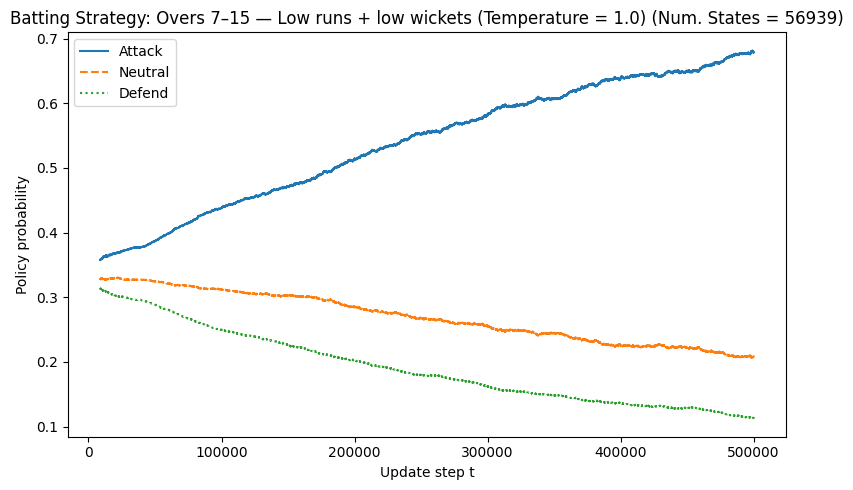

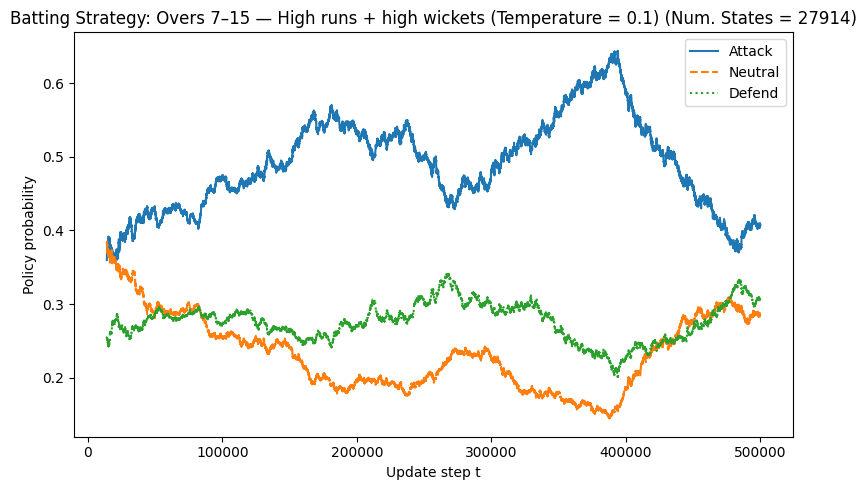

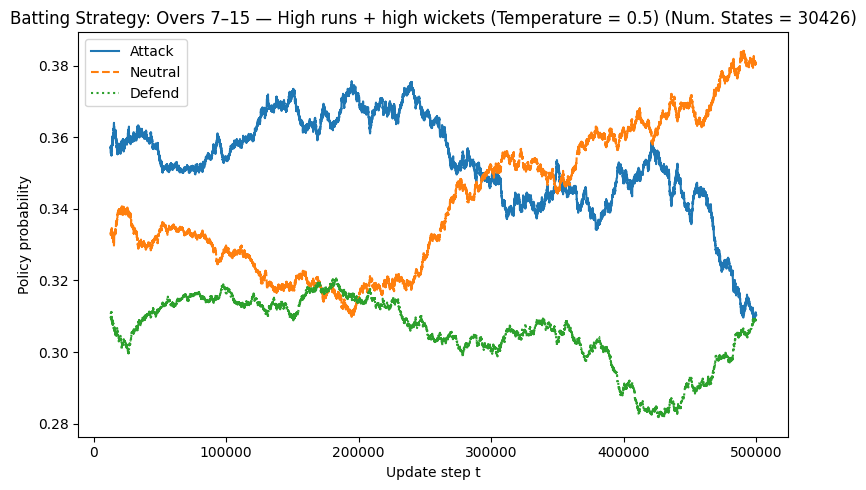

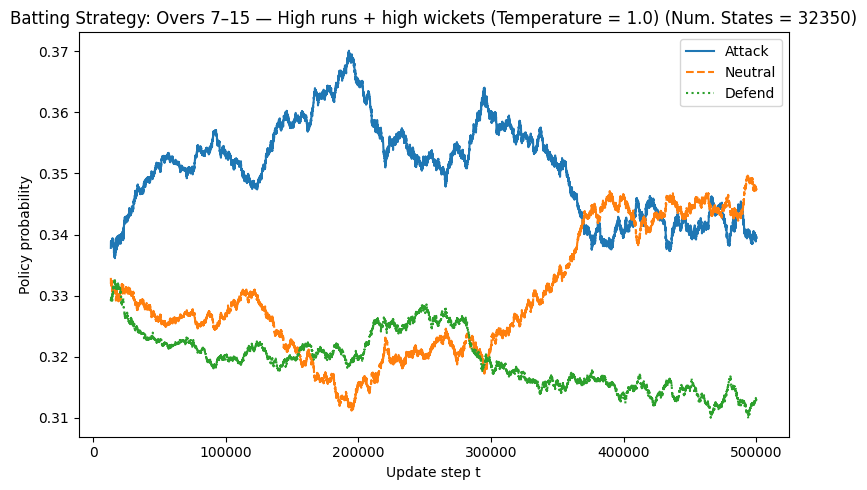

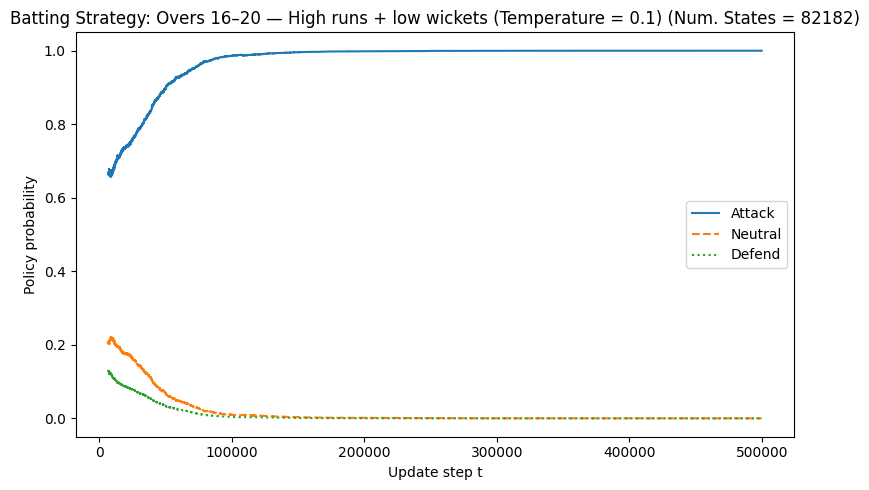

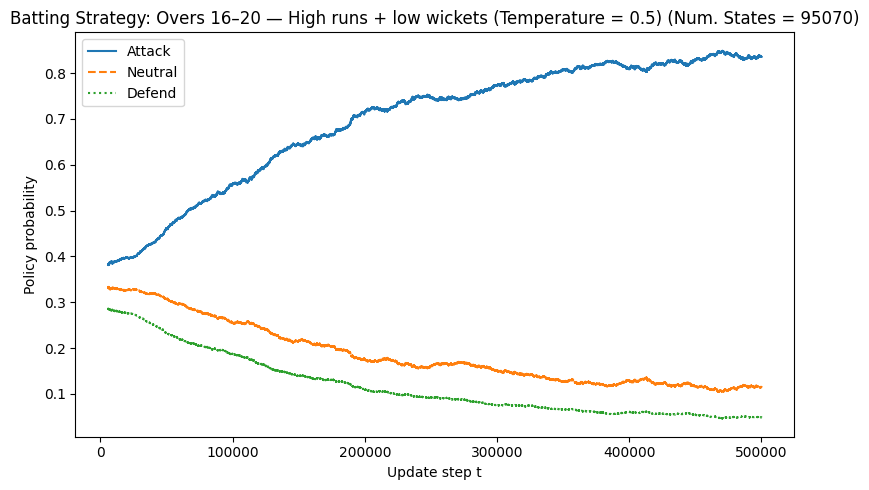

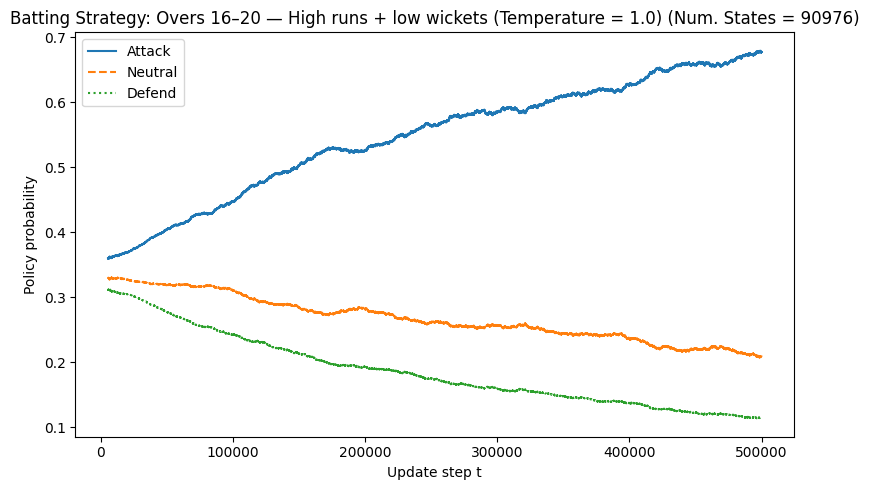

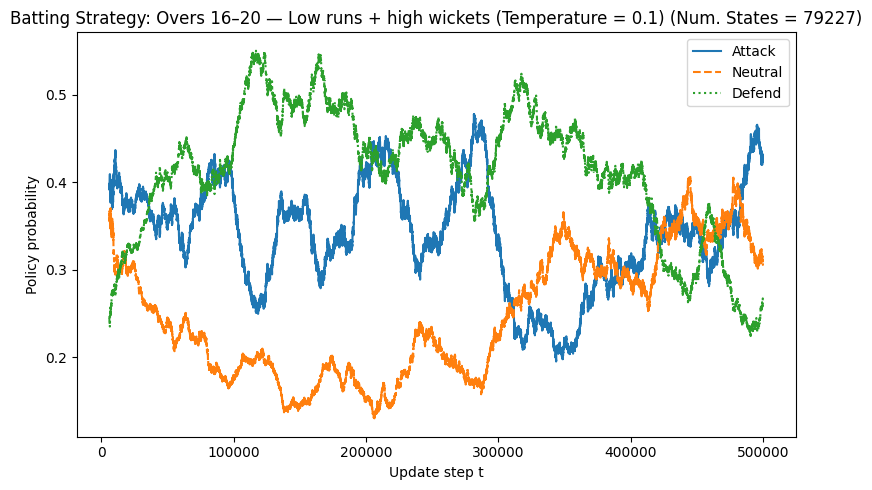

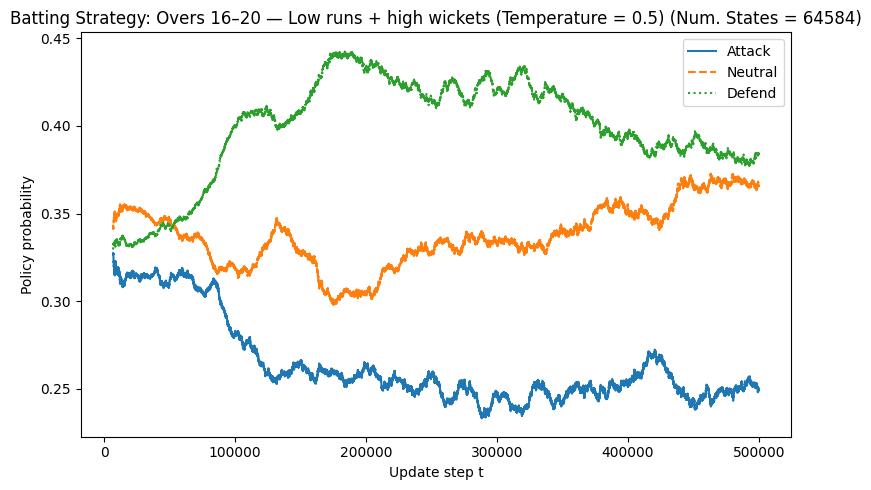

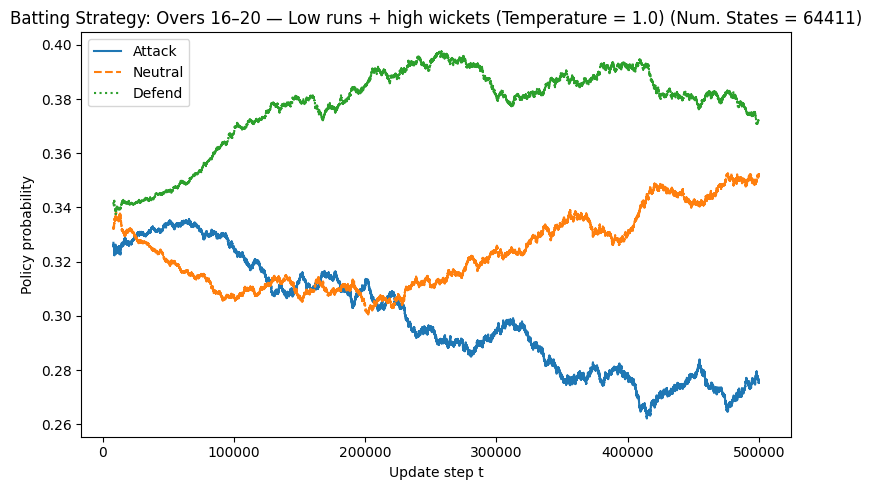

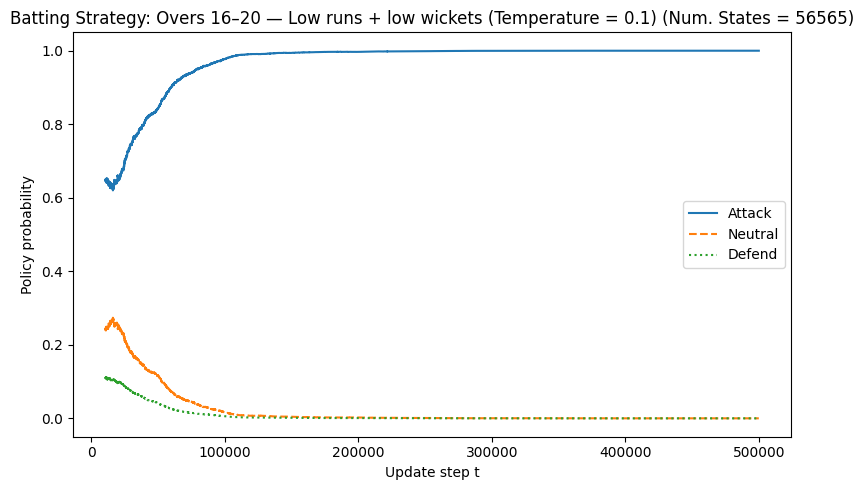

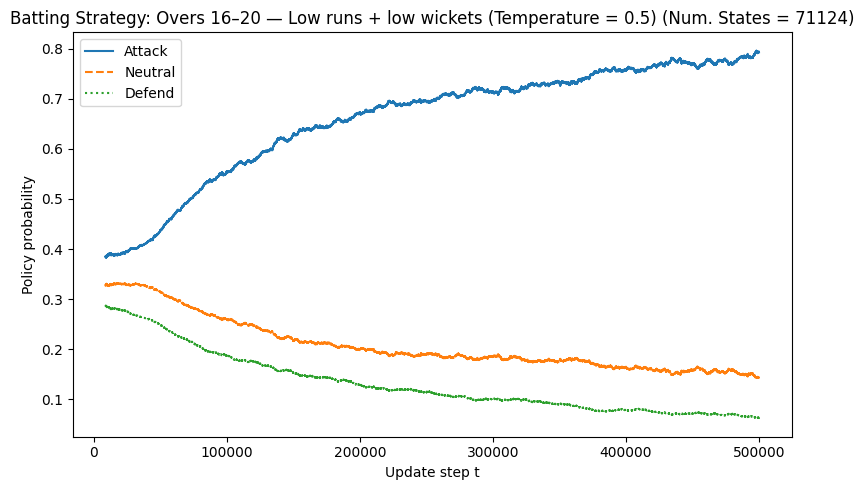

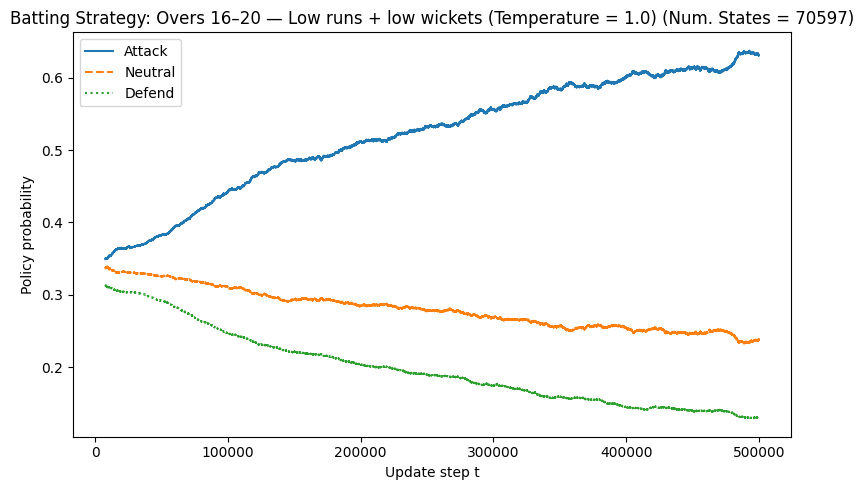

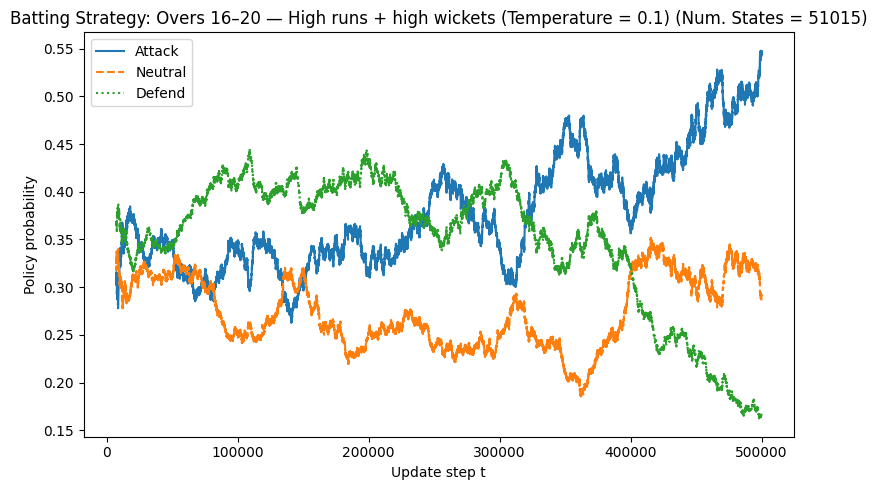

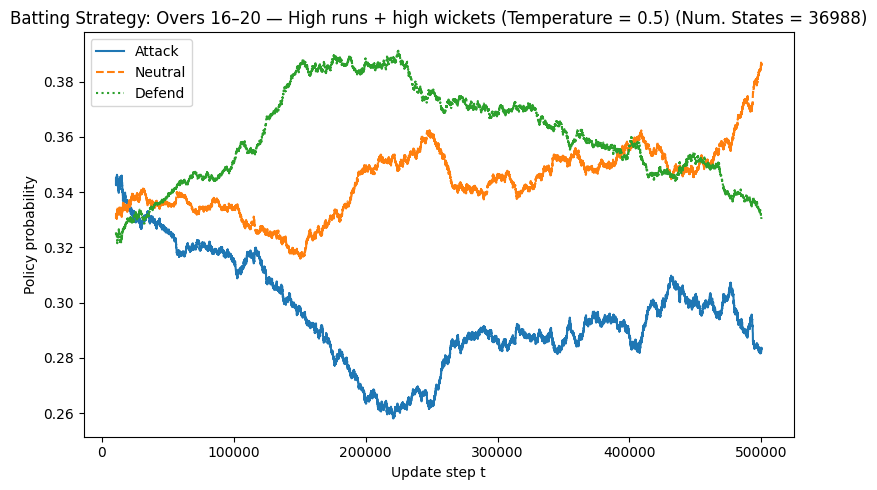

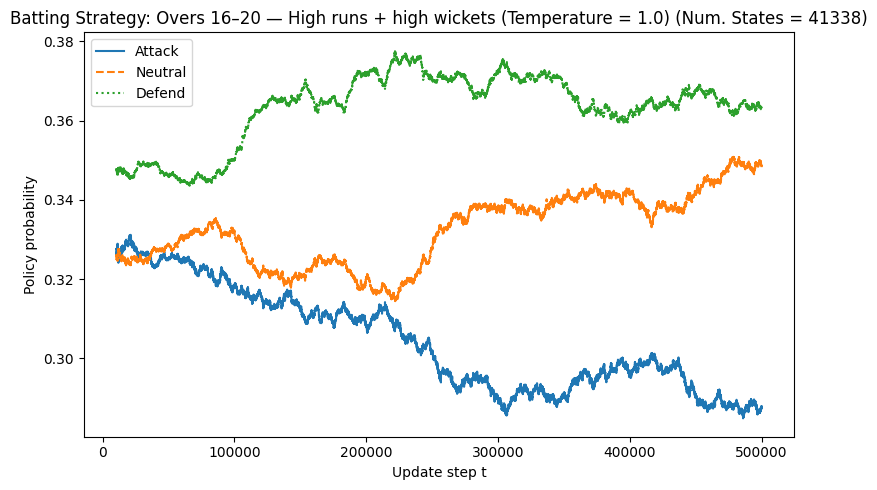

In [ ]:
# Assumes you already have:
# - df_01, df_05, df_10
# - policy_time_series(df, mask, tau, window=...)
# - plot_policy_comparison(series_by_tau, title_prefix=...)

# ----------------------------
# Define your state "buckets"
# ----------------------------
over_ranges = {
    "Overs 0–6":  (0, 6),
    "Overs 7–15": (7, 15),
    "Overs 16–20": (16, 20),
}

def make_masks(df, o_lo, o_hi):
    # restrict to over range FIRST
    in_over = df["over"].between(o_lo, o_hi)
    df_o = df.loc[in_over]

    if df_o.empty:
        return {}

    # compute MEDIANS conditional on over range
    r_med = df_o["runs"].median()
    w_med = df_o["wickets"].median()

    return {
        "Low runs + high wickets":
            in_over
            & (df["runs"] <= r_med)
            & (df["wickets"] > w_med),

        "High runs + low wickets":
            in_over
            & (df["runs"] > r_med)
            & (df["wickets"] <= w_med),

        "Low runs + low wickets":
            in_over
            & (df["runs"] <= r_med)
            & (df["wickets"] <= w_med),

        "High runs + high wickets":
            in_over
            & (df["runs"] > r_med)
            & (df["wickets"] > w_med),
    }

WINDOW = 5_000  # rolling window in policy_time_series

dfs_by_tau = {0.1: df_01, 0.5: df_05, 1.0: df_10}

for over_name, (o_lo, o_hi) in over_ranges.items():
    for bucket_name in ["High runs + low wickets",
                        "Low runs + high wickets",
                        "Low runs + low wickets",
                        "High runs + high wickets"]:

        # build per-tau series for THIS (over-range, bucket)
        series = {}
        any_nonempty = False

        for tau, df in dfs_by_tau.items():
            masks = make_masks(df, o_lo, o_hi)
            mask = masks[bucket_name]

            # skip if nothing in this bucket for this tau
            if mask.sum() == 0:
                continue

            any_nonempty = True
            series[tau] = policy_time_series(df, mask, tau=tau, window=WINDOW)

        if not any_nonempty:
            continue

        plot_policy_comparison(
            series,
            title_prefix=f"Batting Strategy: {over_name} — {bucket_name}"
        )


In [120]:
# ---- load histories ----
bowling_q_hist_01 = joblib.load("../data/temperature-0.1/bowling/q_history.joblib")
bowling_q_hist_05 = joblib.load("../data/temperature-0.5/bowling/q_history.joblib")
bowling_q_hist_10 = joblib.load("../data/temperature-1.0/bowling/q_history.joblib")

bowling_df_01 = q_history_to_df(bowling_q_hist_01)
bowling_df_05 = q_history_to_df(bowling_q_hist_05)
bowling_df_10 = q_history_to_df(bowling_q_hist_10)

KeyboardInterrupt: 

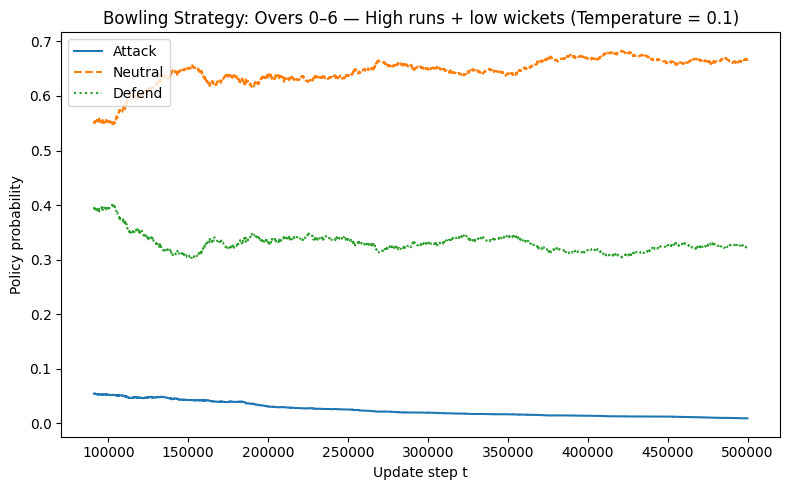

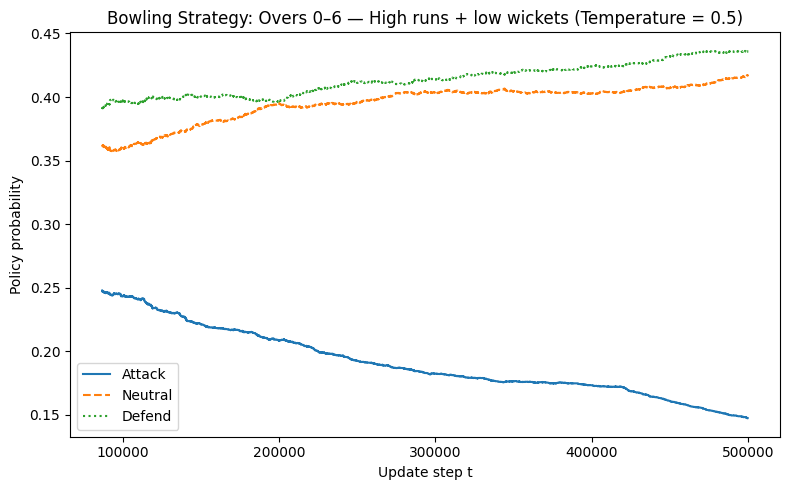

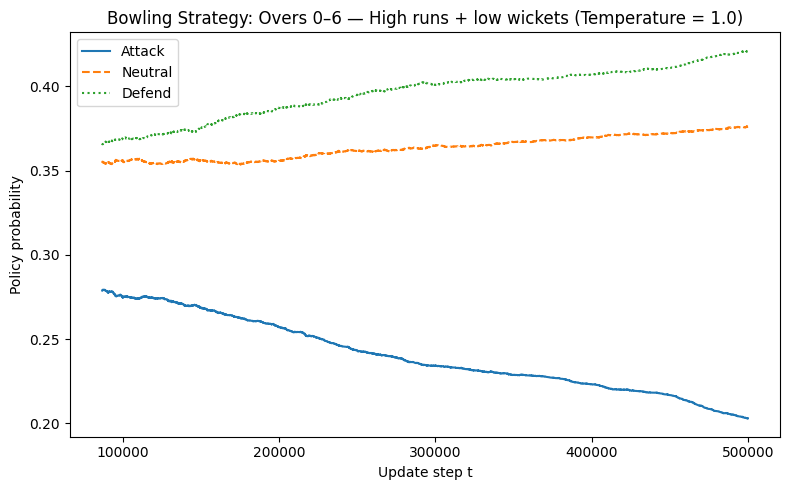

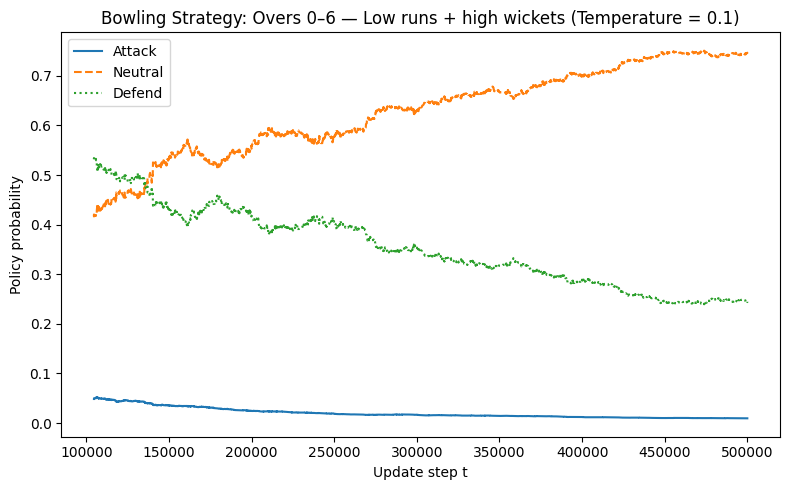

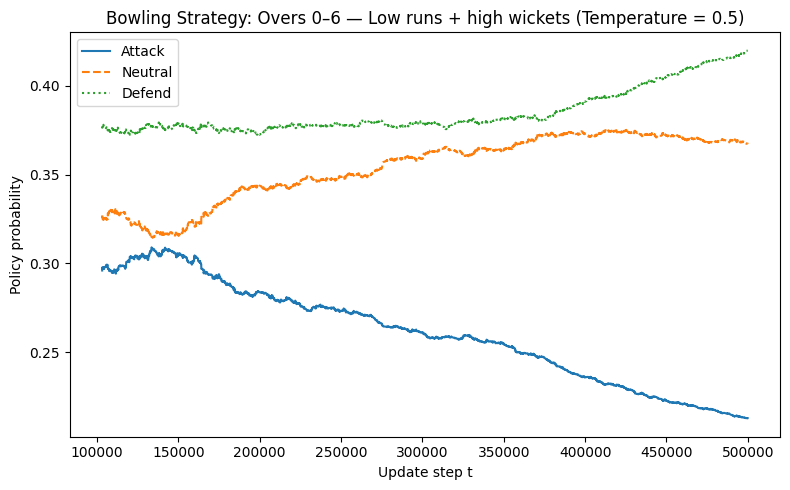

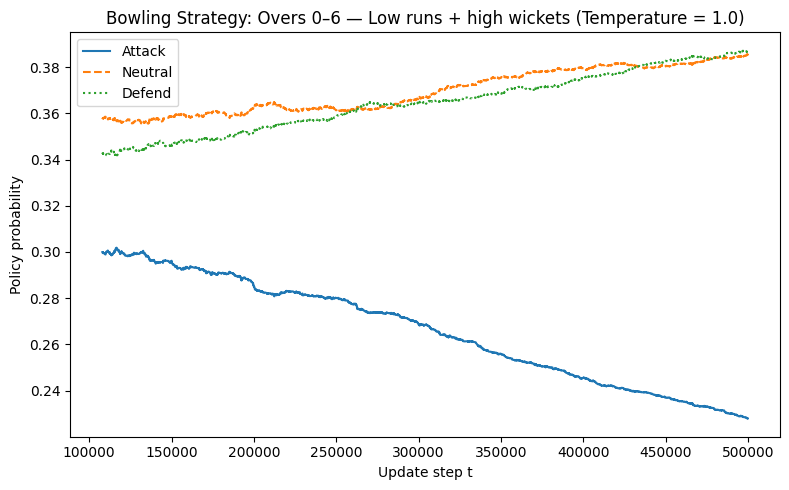

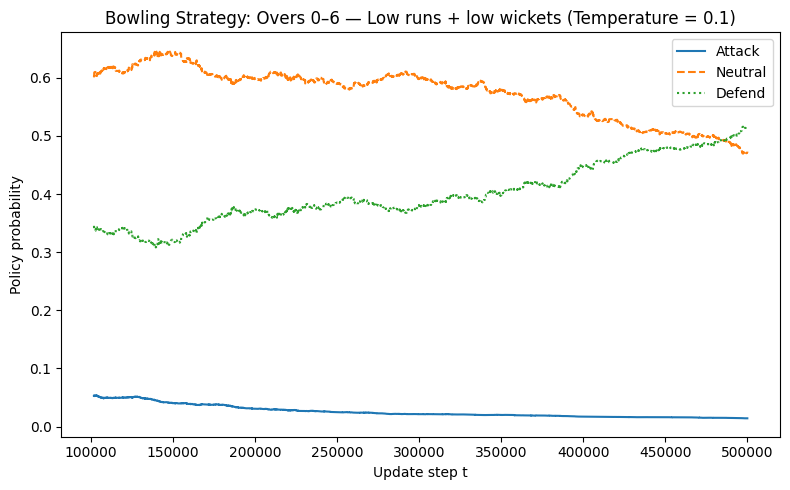

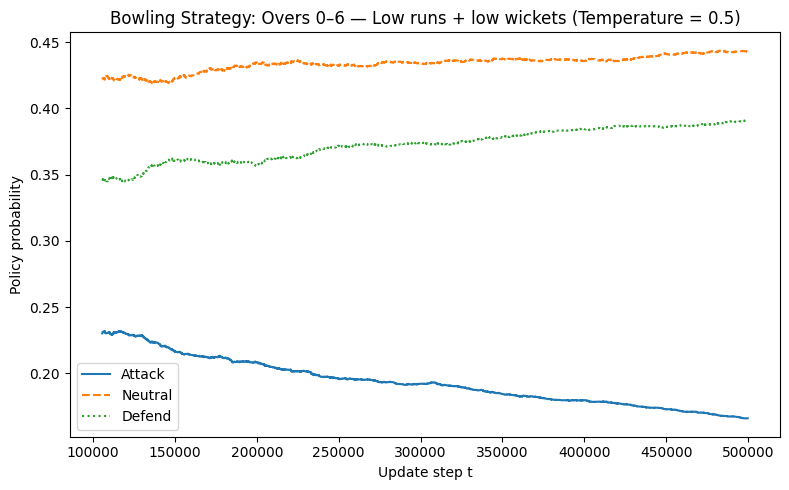

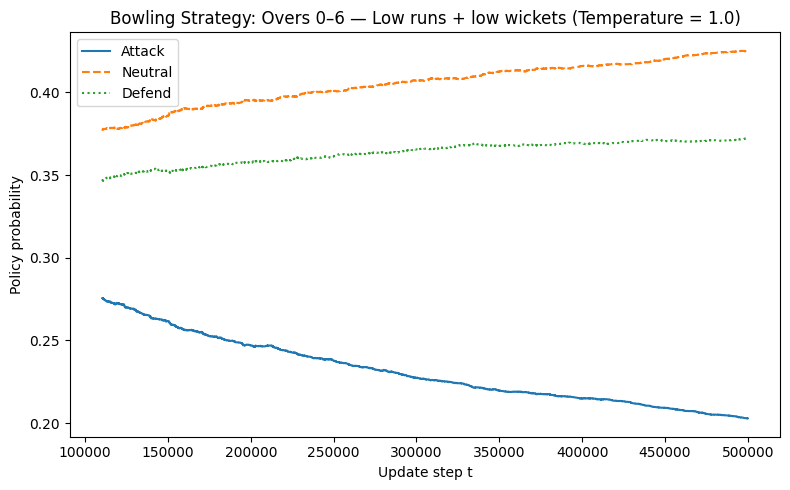

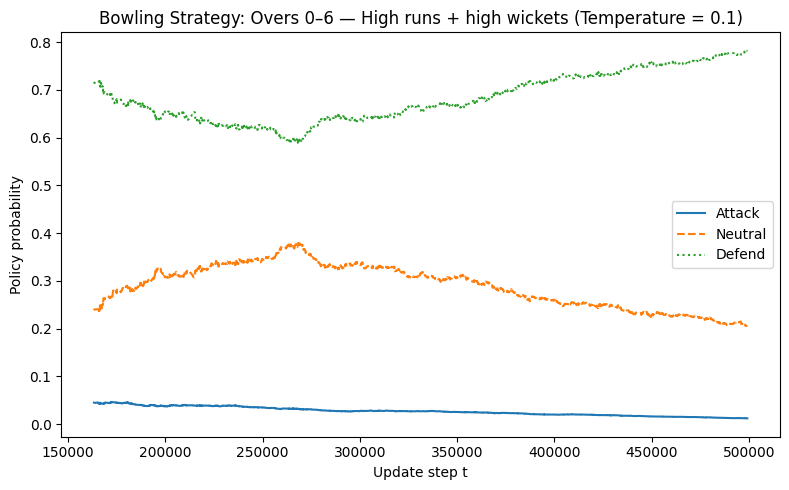

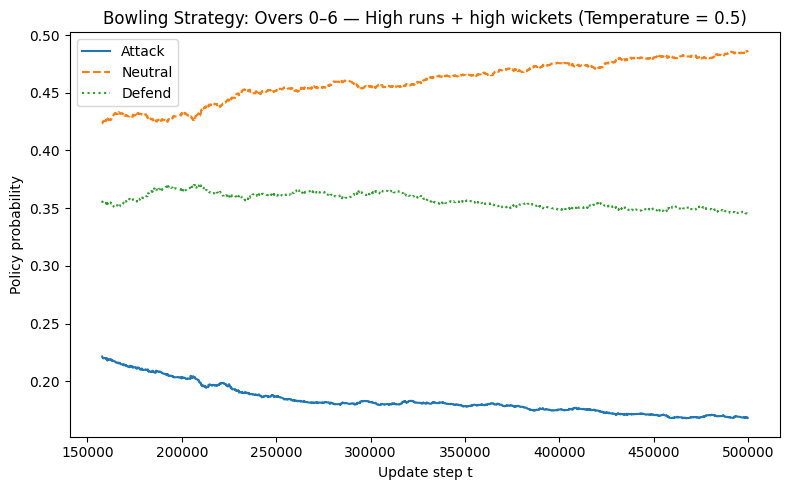

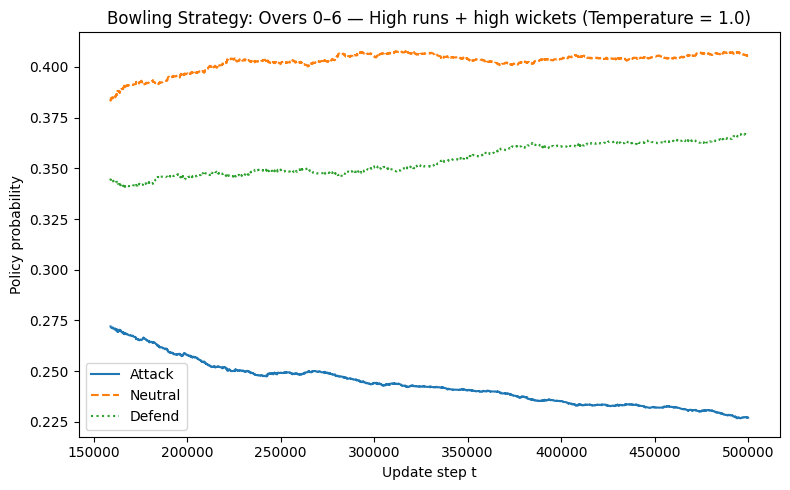

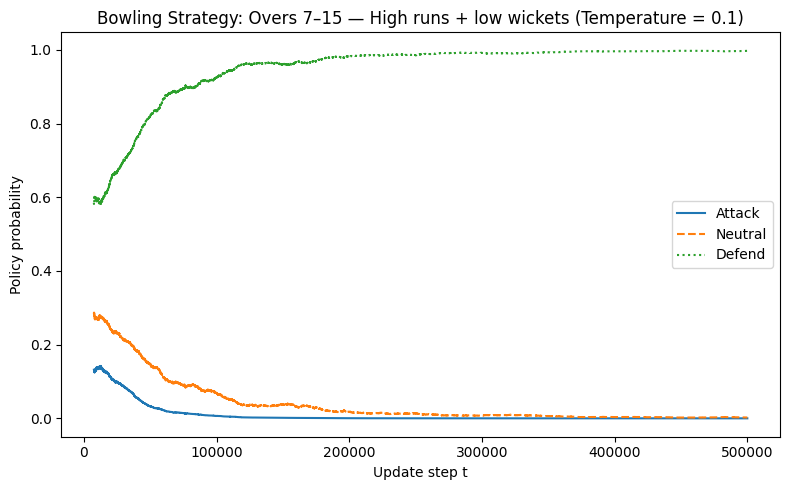

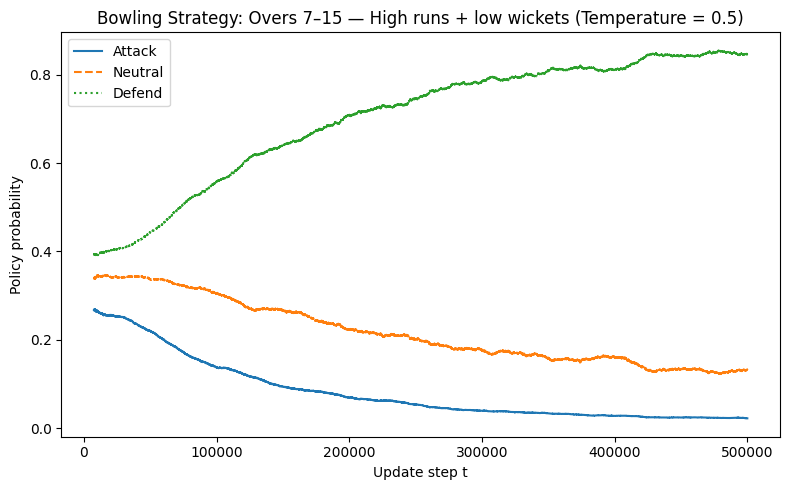

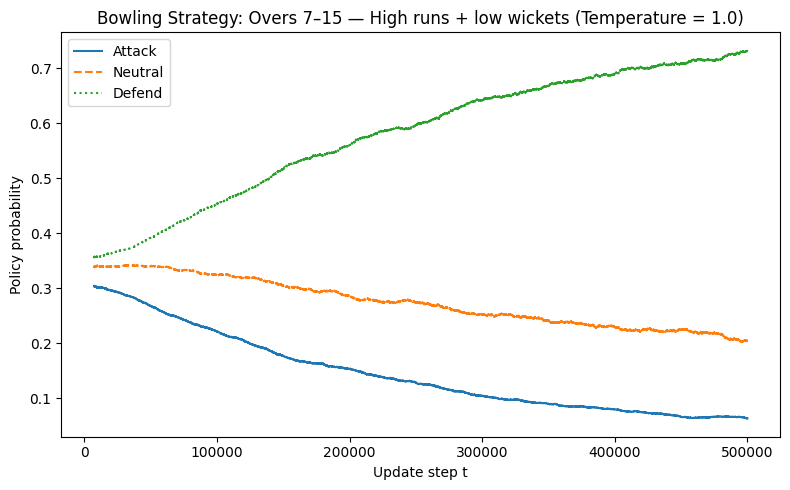

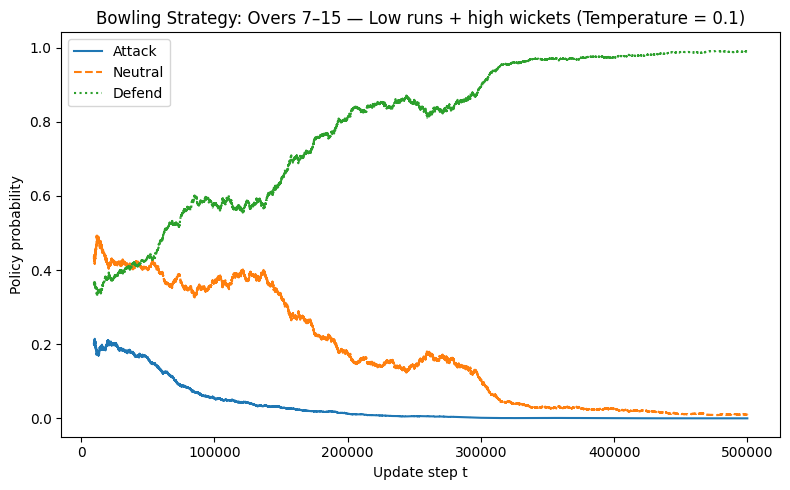

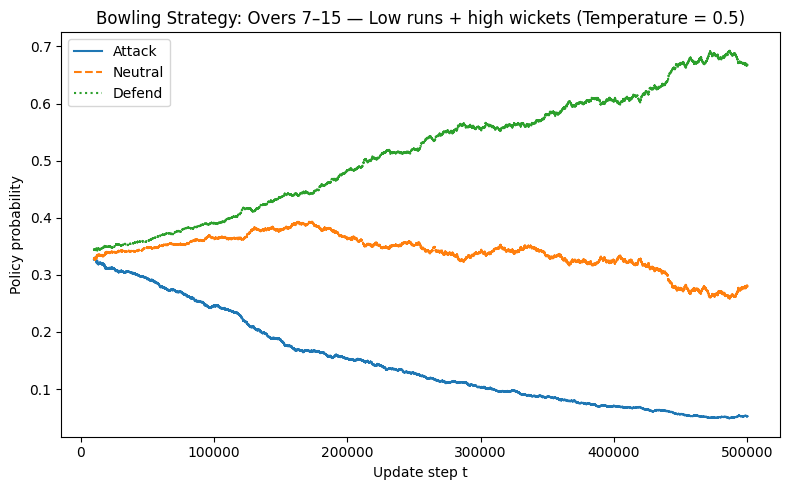

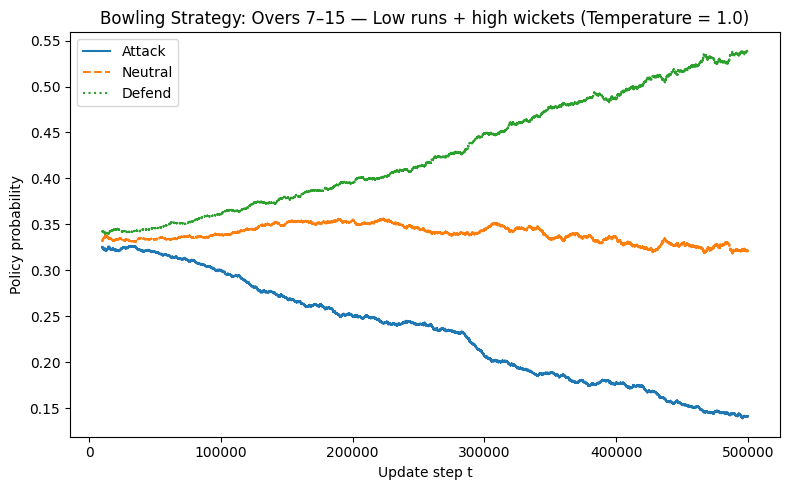

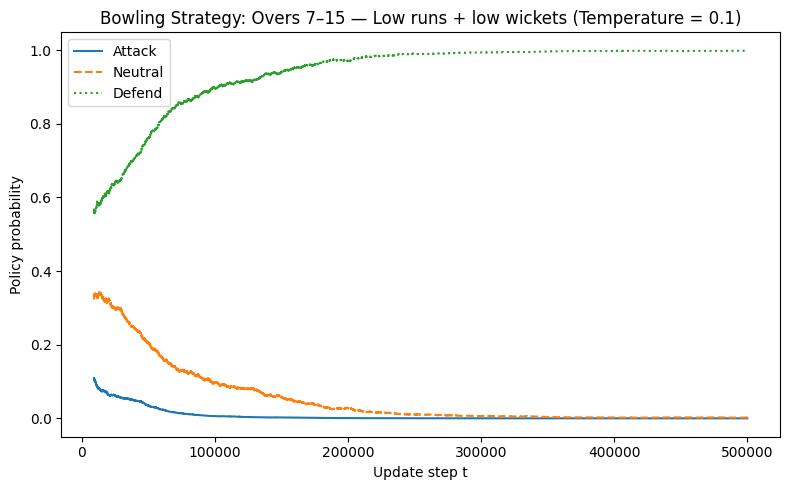

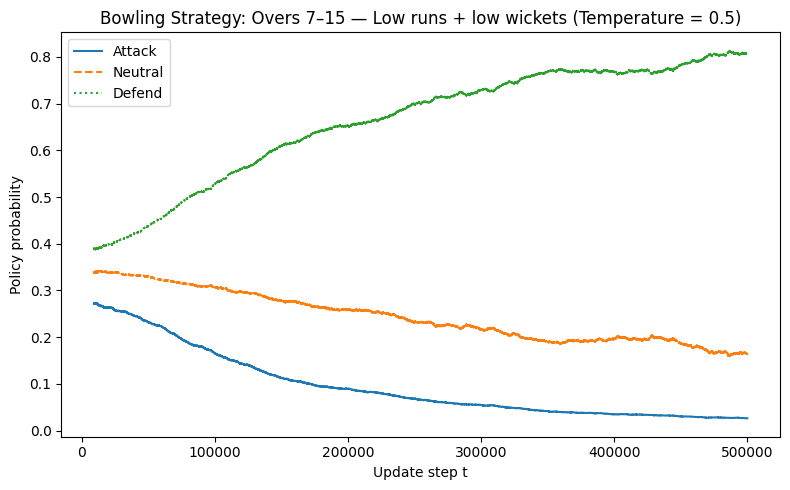

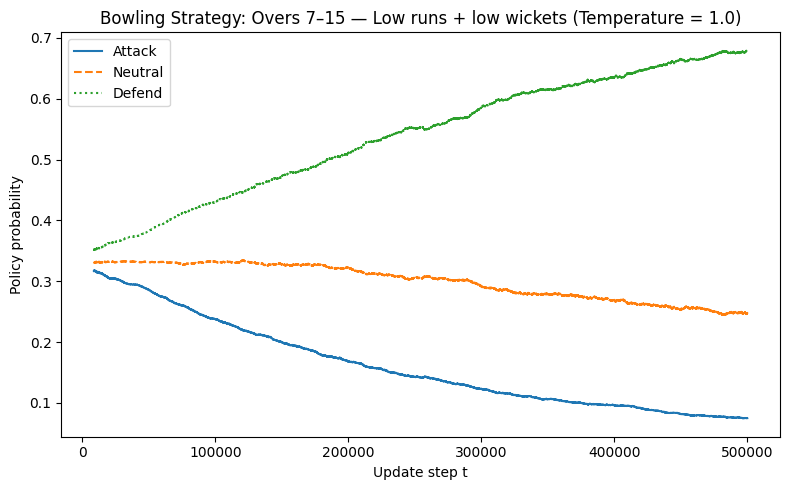

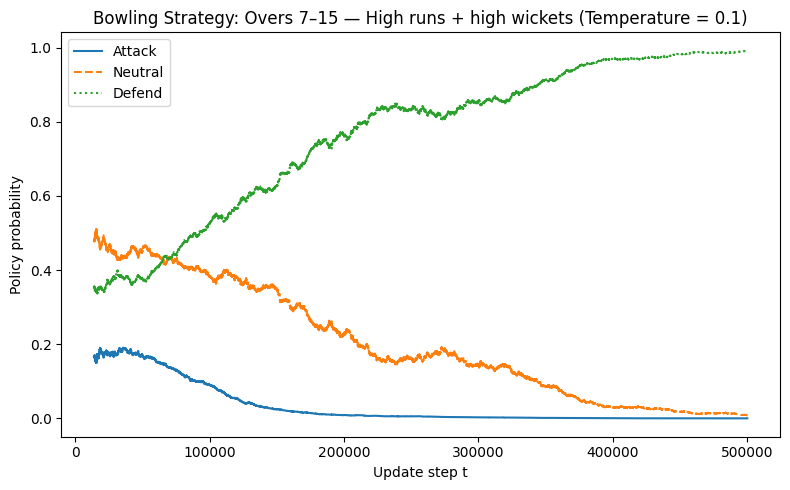

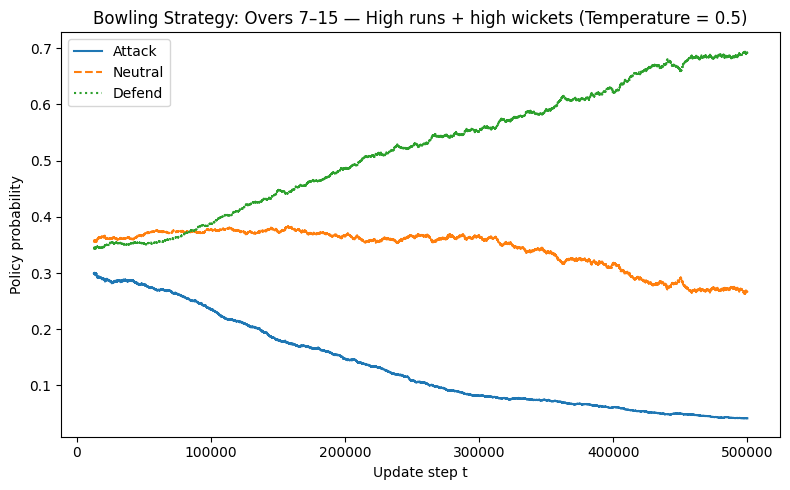

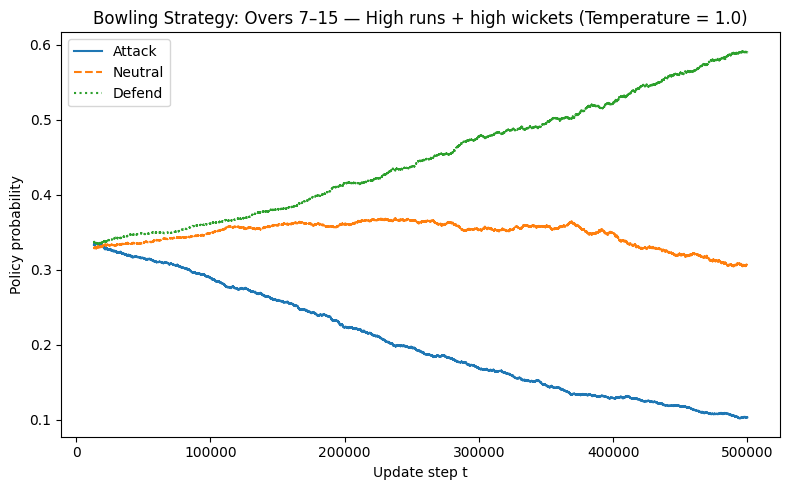

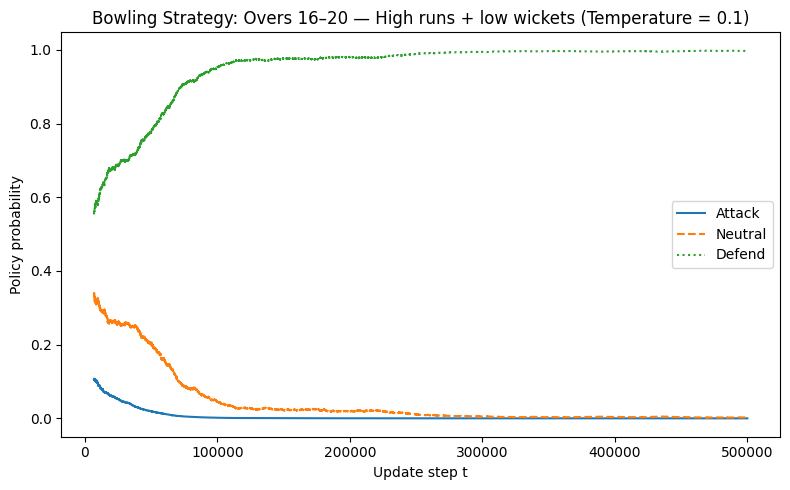

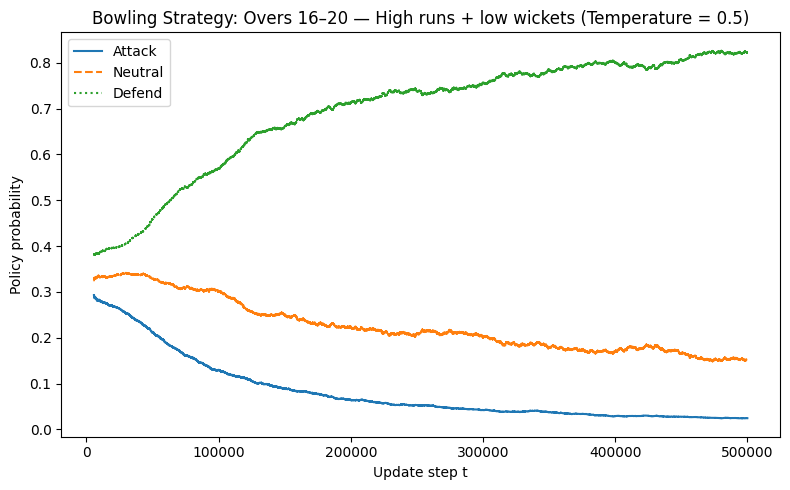

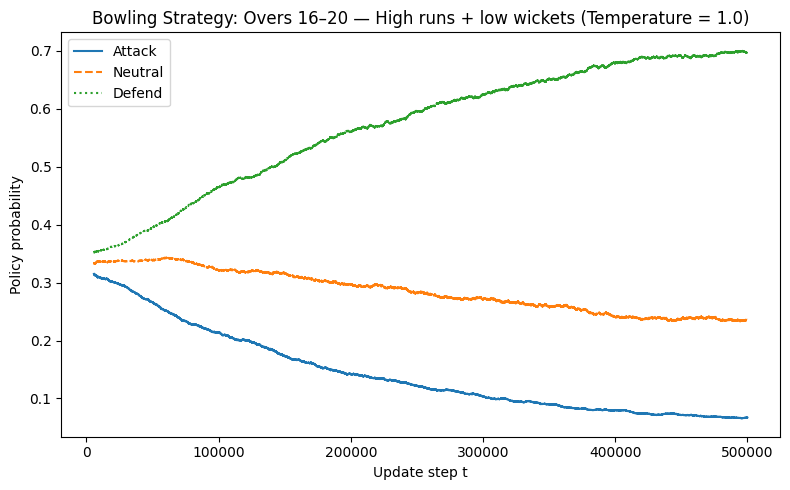

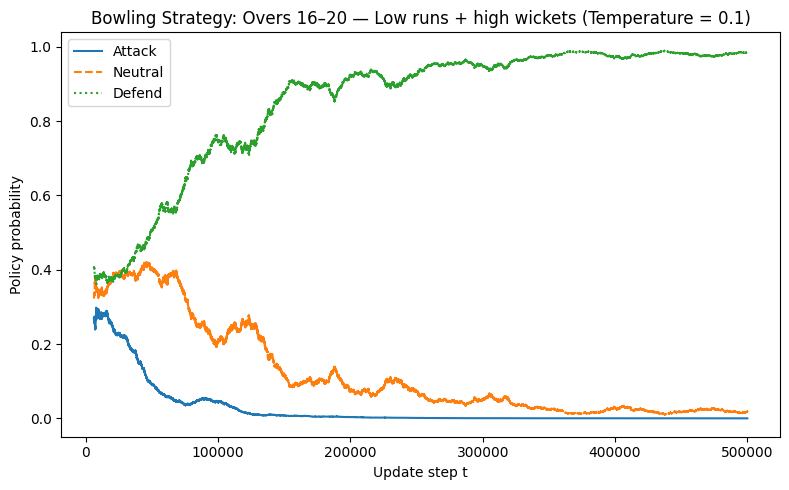

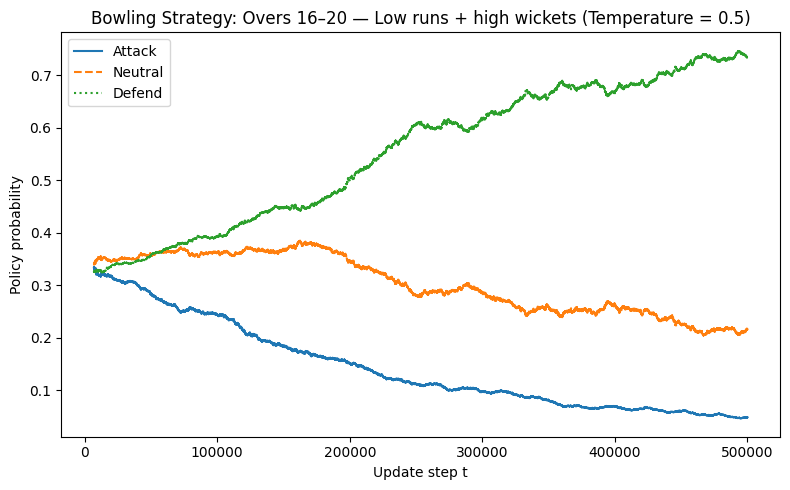

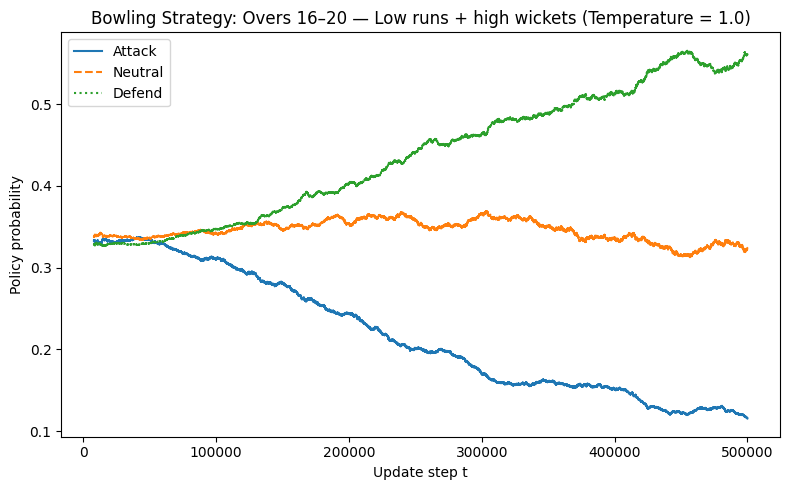

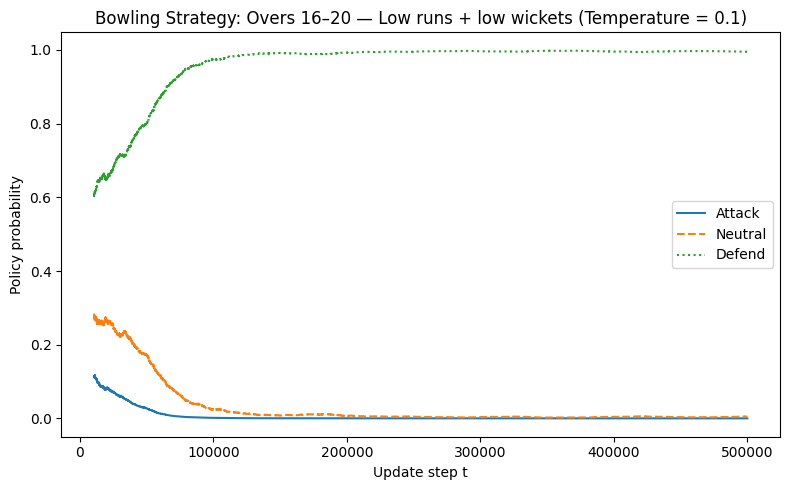

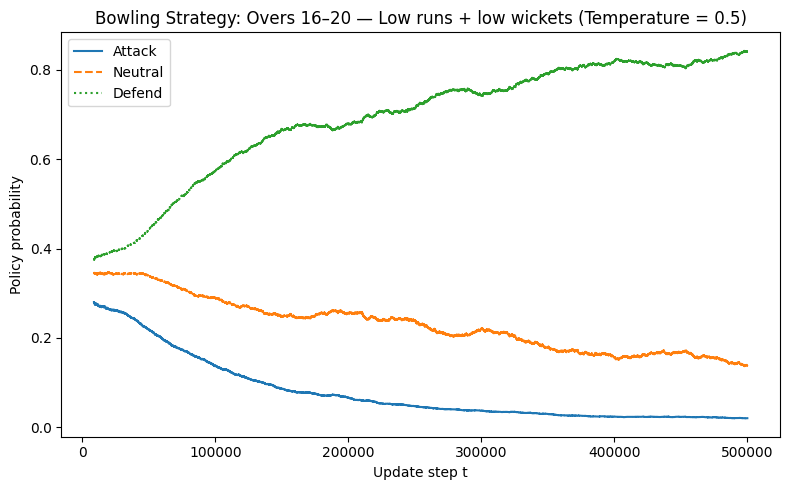

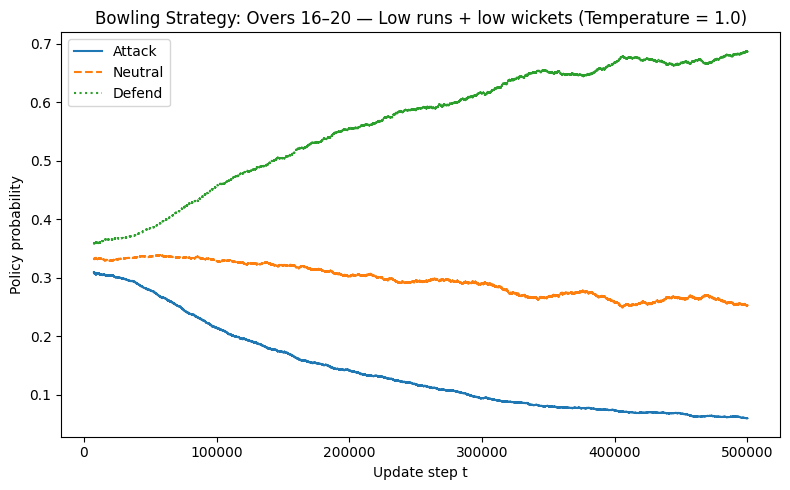

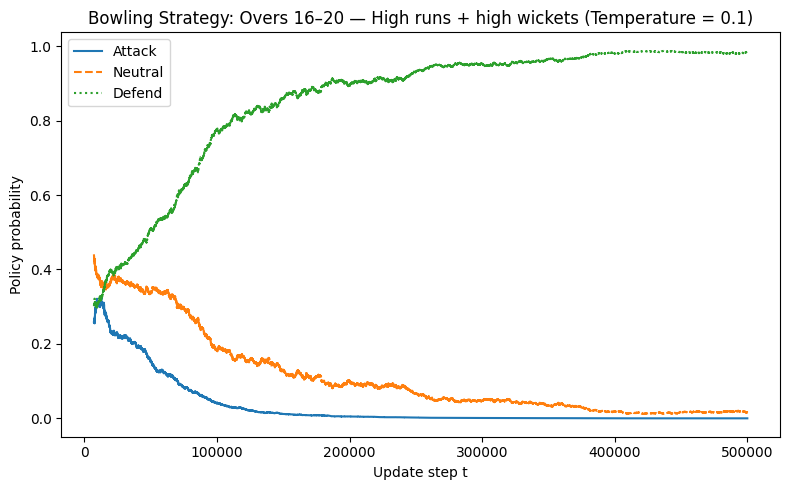

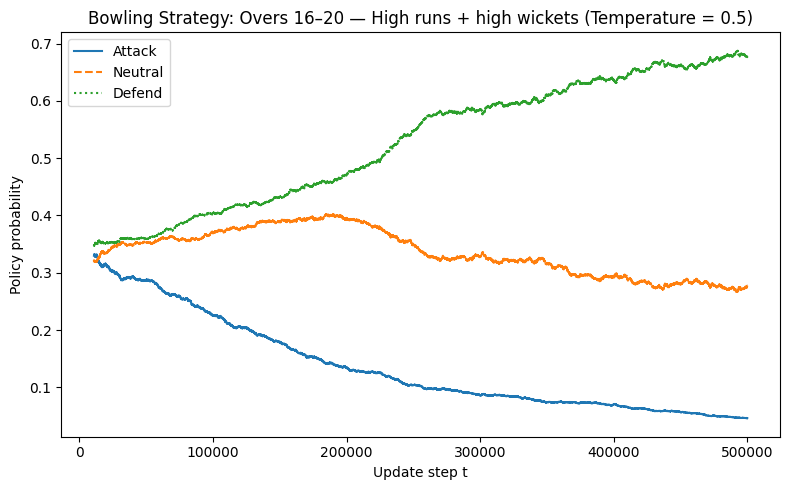

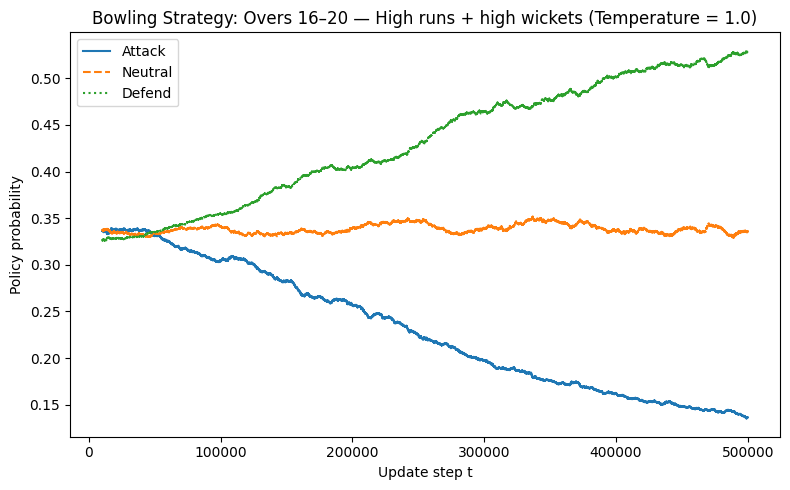

In [ ]:

WINDOW = 5_000  # rolling window in policy_time_series

dfs_by_tau = {0.1: bowling_df_01, 0.5: bowling_df_05, 1.0: bowling_df_10}

for over_name, (o_lo, o_hi) in over_ranges.items():
    for bucket_name in ["High runs + low wickets",
                        "Low runs + high wickets",
                        "Low runs + low wickets",
                        "High runs + high wickets"]:

        # build per-tau series for THIS (over-range, bucket)
        series = {}
        any_nonempty = False

        for tau, df in dfs_by_tau.items():
            masks = make_masks(df, o_lo, o_hi)
            mask = masks[bucket_name]

            # skip if nothing in this bucket for this tau
            if mask.sum() == 0:
                continue

            any_nonempty = True
            series[tau] = policy_time_series(df, mask, tau=tau, window=WINDOW)

        if not any_nonempty:
            continue

        plot_policy_comparison(
            series,
            title_prefix=f"Bowling Strategy: {over_name} — {bucket_name}"
        )


In [ ]:
def softmax(X, tau=1.0):
    """
    Row-wise softmax with temperature.

    X : array-like, shape (N, n)
    """
    X = np.asarray(X, dtype=float)
    Z = X / tau
    Z -= Z.max(axis=1, keepdims=True)
    E = np.exp(Z)
    return E / E.sum(axis=1, keepdims=True)


In [68]:
import joblib
hist = joblib.load(f"../data/temperature-0.5/batting/q_updates.joblib")

In [69]:
import pandas as pd
import numpy as np

states = hist["state"]
rewards = hist["reward"]

df = pd.DataFrame(states, columns=["over", "runs", "wickets"])
df["reward"] = np.asarray(rewards, dtype=float)


In [70]:
mask = df["over"].between(7, 15) 
runs_median = df[mask]["runs"].quantile(0.5)
wkts_median = df[mask]["wickets"].quantile(0.5)

runs_median, wkts_median

(np.float64(91.0), np.float64(4.0))

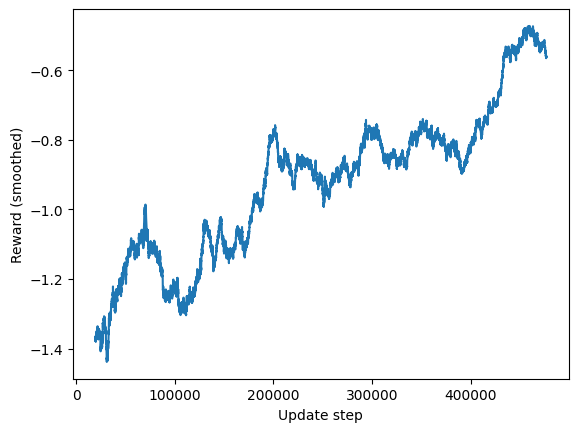

In [71]:
import matplotlib.pyplot as plt

mask = df["over"].between(7, 15) & (df["wickets"] >= 4) & (df["runs"] >= 91)
window = 4000  # try 200–2000 depending on length
smoothed = df[mask]["reward"].rolling(window, center=True).mean()

plt.figure()
plt.plot(smoothed)
plt.xlabel("Update step")
plt.ylabel("Reward (smoothed)")
plt.show()